In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

import keras
from keras import Sequential, callbacks, regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, LeakyReLU, BatchNormalization
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Load data and preprocessing

In [4]:
def load_data():
    raw_data = np.genfromtxt('train.csv', dtype=str, skip_header=1, delimiter=',')
    
    return raw_data

raw_data = load_data()

In [5]:
def preprocessing(raw_data):
    #shuffle data
    datagen = ImageDataGenerator()
    seed = 10000
    np.random.seed(seed)
    np.random.shuffle(raw_data)
    
    #split to train and valid
    #double size of train for augmentation data
    raw_train = raw_data[:round(raw_data.shape[0] * 0.8)]
    raw_valid = raw_data[round(raw_data.shape[0] * 0.8):]
    
    
    no_x_train = np.empty((raw_train.shape[0], 48, 48, 1), dtype=float)
    no_y_train = np.zeros((raw_train.shape[0], 7))
    
    aug_x_train = np.empty((raw_train.shape[0] * 2, 48, 48, 1), dtype=float)
    aug_y_train = np.zeros((raw_train.shape[0] * 2, 7))
    
    x_valid = np.empty((raw_valid.shape[0], 48, 48, 1), dtype=float)
    y_valid = np.zeros((raw_valid.shape[0], 7))
    
    timer = 0   
    
    for i in range(0, raw_train.shape[0]):
        no_x_train[i] = np.array(raw_train[i][1].split(' '), dtype=float).reshape(48, 48, 1)
        no_y_train[i][int(raw_train[i][0])] = 1
    
        #original data
        aug_x_train[timer] = np.array(raw_train[i][1].split(' '), dtype=float).reshape(48, 48, 1)
        aug_y_train[timer][int(raw_train[i][0])] = 1
        
        #augmented data
        aug_x_train[timer+1] = datagen.apply_transform(aug_x_train[timer], {'flip_horizontal': True})
        aug_y_train[timer+1] = aug_y_train[timer] 
        
        timer+=2
        
    for i in range(raw_valid.shape[0]):
        x_valid[i] = np.array(raw_valid[i][1].split(' '), dtype=float).reshape(48, 48, 1)
        y_valid[i][int(raw_valid[i][0])] = 1
        
    return aug_x_train, aug_y_train, no_x_train, no_y_train, x_valid, y_valid

x_train, y_train, no_x_train, no_y_train, x_valid, y_valid = preprocessing(raw_data)

In [6]:
def norm_255(data):
    data = data/255

    return data

In [7]:
x_train_norm = norm_255(x_train)
x_valid_norm = norm_255(x_valid)
x_train_norm_no_aug = norm_255(no_x_train)

## CNN

### training

In [42]:
def CNNtrain():
    model = Sequential()
    
    #input 48 * 48
    #output 46 * 46  #output 23 * 23 
    model.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=(48, 48, 1), padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    #output 22 * 22  #output 11 * 11
    model.add(Conv2D(256, (5, 5), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(units=256,  activity_regularizer=regularizers.l2(1e-7)))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=512, activity_regularizer=regularizers.l2(1e-7)))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=7, activation='softmax'))
    
    #es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)
    mc = ModelCheckpoint('best_model_{val_accuracy:.2f}.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
    csv_logger = CSVLogger('log.csv')
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=256,\
                  epochs=35, callbacks=[mc, csv_logger])
    
    return model, history

In [43]:
model, history = CNNtrain()

Train on 45934 samples, validate on 5742 samples
Epoch 1/35
 8960/45934 [====>.........................] - ETA: 43s - loss: 2.4399 - accuracy: 0.2076

KeyboardInterrupt: 

## evalute on test set

In [8]:
#load model
best_model = keras.models.load_model('best_model_0.63.h5')

In [9]:
score_test = best_model.evaluate(x_valid, y_valid)
print(f'score_train = {score_test[1]}')

5742/5742 [==============================] - 5s 920us/step
score_train = 0.8470916152000427


## accuracy and loss against epochs

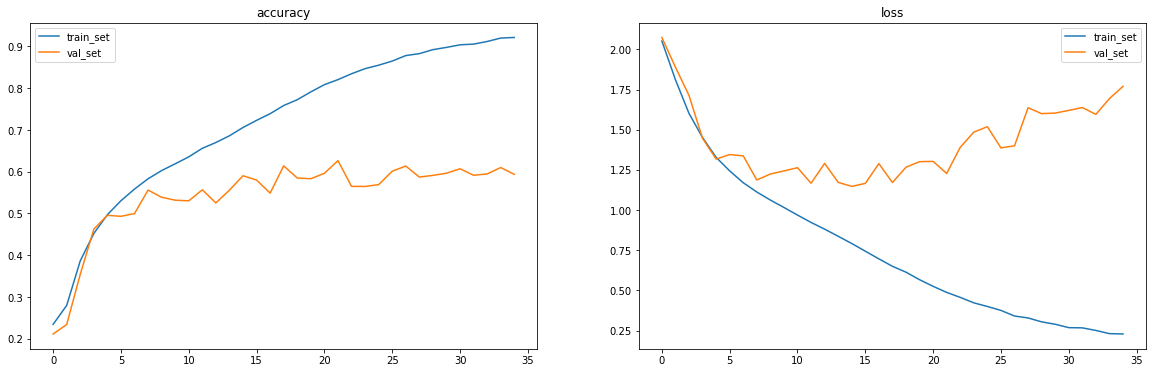

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
log = pd.read_csv('log1.csv')
x = range(35)
y1 = np.array(log['accuracy'])
y2 = np.array(log['val_accuracy'])

axs[0].plot(x, y1, label = 'train_set')
axs[0].plot(x, y2, label = 'val_set')
axs[0].legend()
axs[0].set_title('accuracy')

y3 = np.array(log['loss'])
y4 = np.array(log['val_loss'])

axs[1].plot(x, y3, label = 'train_set')
axs[1].plot(x, y4, label = 'val_set')
axs[1].legend()
axs[1].set_title('loss')

plt.savefig('accuracy_loss', dpi=100, bbox_inches='tight')
plt.show()

## confusion matrix

In [11]:
y_pred = best_model.predict(x_valid)

In [12]:
y_pred_decode = np.empty((x_valid.shape[0],), dtype=float)
y_valid_decode = np.empty((x_valid.shape[0],), dtype=float)

for i in range(x_valid.shape[0]):
    y_pred_decode[i] = np.argmax(y_pred[i])
    y_valid_decode[i] = np.argmax(y_valid[i])

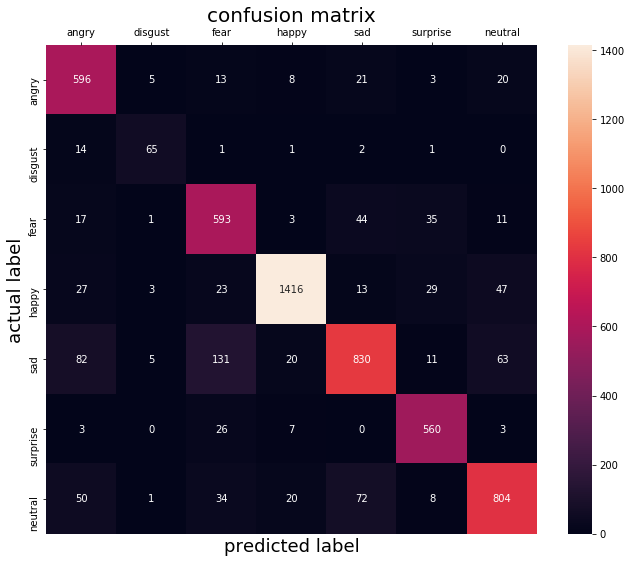

In [13]:
cm = confusion_matrix(y_pred_decode, y_valid_decode, normalize='true')
label = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
df_cm = pd.DataFrame(cm, index=label, columns=label)

fig, ax = plt.subplots(figsize=(11, 9))
ax = sn.heatmap(df_cm, fmt='.2f', annot=True)
ax.set_title('confusion matrix', fontsize=20)
ax.set_xlabel('predicted label', fontsize=18)
ax.set_ylabel('actual label', fontsize=18)
ax.xaxis.set_ticks_position('top')
plt.savefig('confusion_matrix', dpi=100, bbox_inches='tight')
plt.show()

## predict

In [5]:
#load test data
raw_data_test = np.genfromtxt('test.csv', dtype=str, skip_header=1, delimiter=',')

In [6]:
#process test data
x_test = np.empty((raw_data_test.shape[0], 48, 48, 1), dtype=float)

for i in range(x_test.shape[0]):
    x_test[i] = np.array(raw_data_test[i][1].split(' '), dtype=float).reshape(48, 48, 1) / 255

In [7]:
output = best_model.predict(x_test)

In [8]:
output_id = np.arange(output.shape[0], dtype=int)
output_label = np.zeros(output.shape[0], dtype=int)

for i in range(output.shape[0]):
    output_label[i] = np.argmax(output[i])

df_output = pd.DataFrame({'id': output_id, 
                          'label': output_label}, index=None)

df_output.to_csv('predicted_output.csv', index=False)